# Cifar10 classification tricks

In this notebook you will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label. Note that because the images are so small it is not always very easy to recognise which of the ten classes is on the image, even as a human. After loading the dataset you will train multiple models and compare the performances of the models on the testset.

**Dataset:**  You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* load the original cifar10 data create a train val and test dataset
* visualize samples of cifar10 dataset

* train a random forest on the pixelvalues
* train a cnn from scratch without normalization
* train a cnn from scratch with normalization
* train a cnn from scratch with dropout
* train a cnn from scratch with batchnorm
* train a cnn from scratch with data augmentation

* compare the performances of the models


#### Imports

In the next two cells, we load all the required libraries and functions.

In [1]:
# load required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier


2024-02-25 10:40:12.636148: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-25 10:40:12.656086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 10:40:12.656108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 10:40:12.656687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-25 10:40:12.660381: I tensorflow/core/platform/cpu_feature_guar


### Load and plot the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset. You will use 10'000 for the train and validation dataset.
You will plot one random example of each label and will see
that the images are really small and finally you can convert the lables into the one hot encoding.


In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 8s 0us/step


In [3]:
# separate train val and test dataset
X_train=x_train[0:10000] 
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val=x_train[20000:30000] 
Y_val=to_categorical(y_train[20000:30000],10)

X_test=x_test 
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


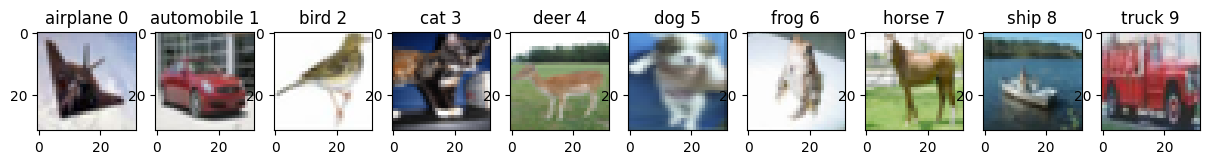

In [4]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+str(np.argmax(Y_train,axis=1)[rmd][0]))

In [5]:
# check the shape of the data
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((10000, 32, 32, 3), (10000, 10), (10000, 32, 32, 3), (10000, 10))

### RF on pixelvalues
In this section you will train a random forest on the raw pixelvalues of the images.


In [6]:
clf = RandomForestClassifier(n_estimators=40,random_state=22)
clf.fit(X_train.reshape(len(X_train),32*32*3), np.argmax(Y_train,axis=1))

RandomForestClassifier(n_estimators=40, random_state=22)

In [7]:
pred=clf.predict(X_test.reshape(len(X_test),32*32*3))
acc=np.average(pred==np.argmax(Y_test,axis=1))
res1 = pd.DataFrame(
          {'Acc' : acc}, index=['rf on pixelvalues'])
res1

,Acc
rf on pixelvalues,0.393


### CNN from scratch without normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is not applied to the data.

In [8]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

2024-02-25 10:40:33.265607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-25 10:40:33.721363: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/10
157/157 [==============================] - 4s 23ms/step - loss: 3.0425 - accuracy: 0.2934 - val_loss: 1.6349 - val_accuracy: 0.4104
Epoch 2/10
157/157 [==============================] - 3s 21ms/step - loss: 1.5155 - accuracy: 0.4470 - val_loss: 1.5108 - val_accuracy: 0.4565
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 1.3151 - accuracy: 0.5291 - val_loss: 1.4803 - val_accuracy: 0.4682
Epoch 4/10
157/157 [==============================] - 2s 15ms/step - loss: 1.1191 - accuracy: 0.5948 - val_loss: 1.4329 - val_accuracy: 0.4994
Epoch 5/10
157/157 [==============================] - 3s 18ms/step - loss: 0.9220 - accuracy: 0.6696 - val_loss: 1.4770 - val_accuracy: 0.5137
Epoch 6/10
157/157 [==============================] - 3s 18ms/step - loss: 0.6940 - accuracy: 0.7595 - val_loss: 1.7398 - val_accuracy: 0.4713
Epoch 7/10
157/157 [==============================] - 4s 23ms/step - loss: 0.5440 - accuracy: 0.8040 - val_loss: 1.9171 - val_accuracy: 0.4961

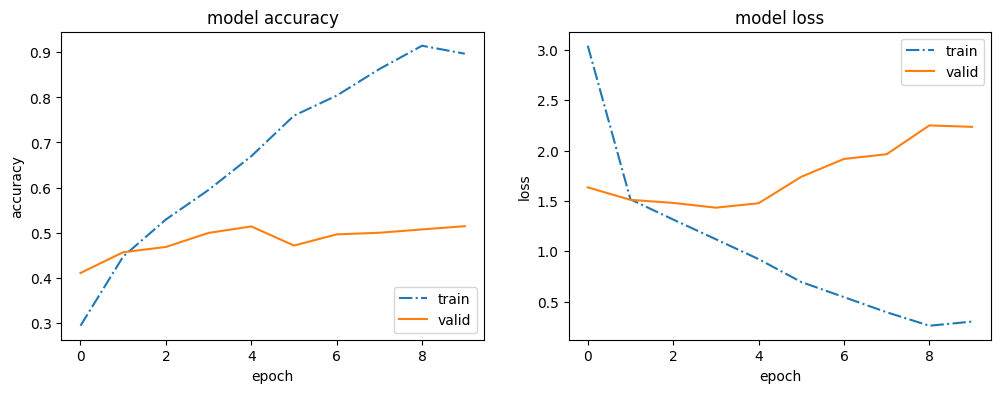

In [10]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [11]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res2 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch without normalization']
)
pd.concat([res1,res2])

313/313 [==============================] - 2s 6ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038


### CNN from scratch with normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is applied to the data.

In [12]:
# normalization
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [13]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [14]:
history = model.fit(X_train_norm, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val_norm, Y_val),verbose=1)

Epoch 1/10
157/157 [==============================] - 4s 23ms/step - loss: 1.8564 - accuracy: 0.3160 - val_loss: 1.6112 - val_accuracy: 0.3965
Epoch 2/10
157/157 [==============================] - 3s 20ms/step - loss: 1.5317 - accuracy: 0.4340 - val_loss: 1.5150 - val_accuracy: 0.4406
Epoch 3/10
157/157 [==============================] - 3s 22ms/step - loss: 1.3718 - accuracy: 0.4992 - val_loss: 1.3724 - val_accuracy: 0.4981
Epoch 4/10
157/157 [==============================] - 3s 22ms/step - loss: 1.2238 - accuracy: 0.5529 - val_loss: 1.3462 - val_accuracy: 0.5109
Epoch 5/10
157/157 [==============================] - 3s 21ms/step - loss: 1.0802 - accuracy: 0.6116 - val_loss: 1.2226 - val_accuracy: 0.5644
Epoch 6/10
157/157 [==============================] - 3s 22ms/step - loss: 0.9369 - accuracy: 0.6642 - val_loss: 1.1745 - val_accuracy: 0.5824
Epoch 7/10
157/157 [==============================] - 3s 20ms/step - loss: 0.7795 - accuracy: 0.7240 - val_loss: 1.1799 - val_accuracy: 0.5945

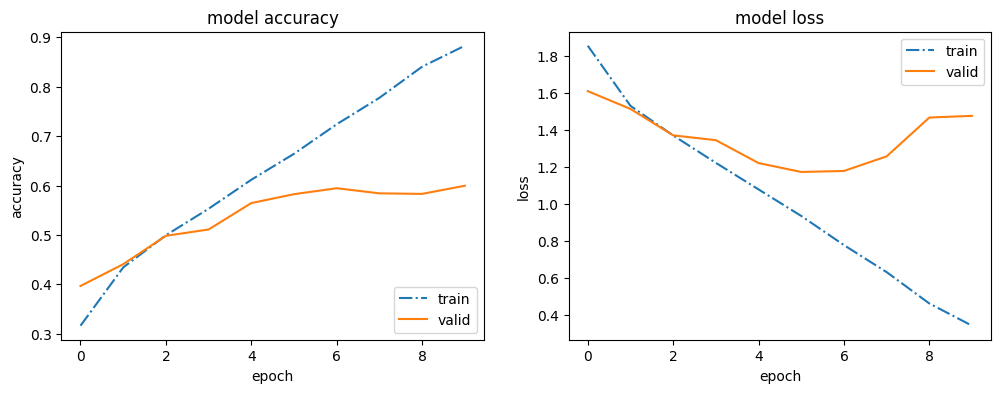

In [15]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [16]:
acc=np.average(np.argmax(model.predict(X_test_norm),axis=1)==np.argmax(Y_test,axis=1))
res3 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with normalization']
)
pd.concat([res1,res2,res3])

313/313 [==============================] - 2s 5ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038
cnn from scratch with normalization,0.5942


### CNN from scratch with Dropout
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use dropout layers in the classification part. Normalization is not used.

In [17]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [18]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=20, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/20
157/157 [==============================] - 4s 23ms/step - loss: 2.5343 - accuracy: 0.2014 - val_loss: 1.7695 - val_accuracy: 0.3416
Epoch 2/20
157/157 [==============================] - 3s 22ms/step - loss: 1.7571 - accuracy: 0.3472 - val_loss: 1.5727 - val_accuracy: 0.4329
Epoch 3/20
157/157 [==============================] - 4s 23ms/step - loss: 1.5971 - accuracy: 0.4181 - val_loss: 1.4912 - val_accuracy: 0.4515
Epoch 4/20
157/157 [==============================] - 3s 22ms/step - loss: 1.4810 - accuracy: 0.4650 - val_loss: 1.4343 - val_accuracy: 0.4799
Epoch 5/20
157/157 [==============================] - 3s 22ms/step - loss: 1.3774 - accuracy: 0.5053 - val_loss: 1.3652 - val_accuracy: 0.5048
Epoch 6/20
157/157 [==============================] - 3s 20ms/step - loss: 1.3041 - accuracy: 0.5377 - val_loss: 1.3134 - val_accuracy: 0.5281
Epoch 7/20
157/157 [==============================] - 3s 21ms/step - loss: 1.2198 - accuracy: 0.5624 - val_loss: 1.3117 - val_accuracy: 0.5239

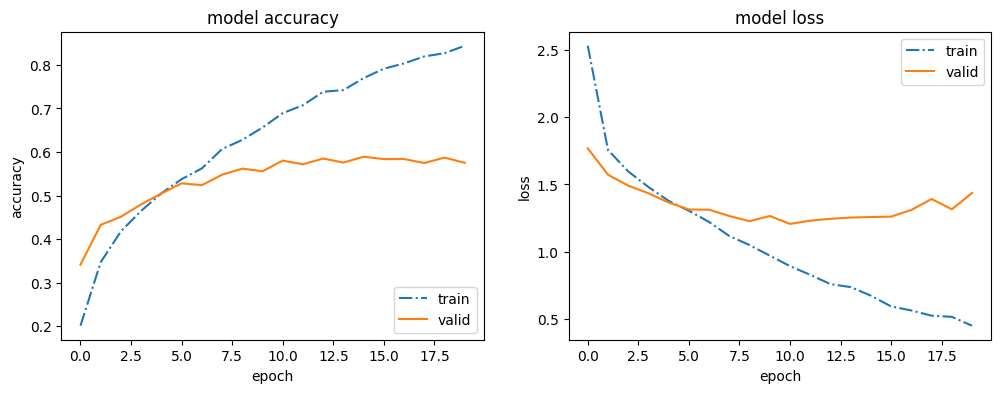

In [19]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [20]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res4 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with dropout']
)
pd.concat([res1,res2,res3,res4])

313/313 [==============================] - 1s 4ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038
cnn from scratch with normalization,0.5942
cnn from scratch with dropout,0.5761


### CNN from scratch with Batchnorm
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use batchnorm on the input and in the convolutional part of the network. Note that we use the original images and do not normalize them.

In [21]:
# not normalized, values between 0 and 255
X_train[0,0:10,0,0]

array([ 59,  16,  25,  33,  50,  71,  97, 115, 137, 154], dtype=uint8)

In [22]:
model  =  Sequential()

model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 32, 32, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 16)       

In [23]:
history = model.fit(X_train, Y_train, 
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=1)

Epoch 1/10


157/157 [==============================] - 5s 28ms/step - loss: 1.7275 - accuracy: 0.3704 - val_loss: 1.7400 - val_accuracy: 0.3741
Epoch 2/10
157/157 [==============================] - 4s 27ms/step - loss: 1.3274 - accuracy: 0.5177 - val_loss: 1.4803 - val_accuracy: 0.4504
Epoch 3/10
157/157 [==============================] - 4s 28ms/step - loss: 1.1406 - accuracy: 0.5848 - val_loss: 1.2505 - val_accuracy: 0.5500
Epoch 4/10
157/157 [==============================] - 4s 24ms/step - loss: 0.9867 - accuracy: 0.6406 - val_loss: 1.1251 - val_accuracy: 0.6041
Epoch 5/10
157/157 [==============================] - 4s 28ms/step - loss: 0.8561 - accuracy: 0.6912 - val_loss: 1.1466 - val_accuracy: 0.6026
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.7385 - accuracy: 0.7345 - val_loss: 1.1236 - val_accuracy: 0.6182
Epoch 7/10
157/157 [==============================] - 4s 27ms/step - loss: 0.6377 - accuracy: 0.7725 - val_loss: 1.1204 - val_accuracy: 0.6236
Epoch 8/10

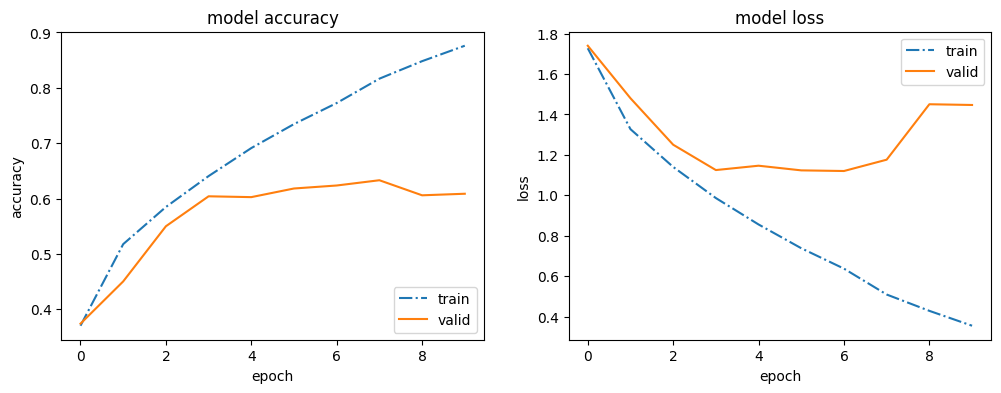

In [24]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [25]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res5 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with batchnorm']
)
pd.concat([res1,res2,res3,res4,res5])

313/313 [==============================] - 1s 2ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038
cnn from scratch with normalization,0.5942
cnn from scratch with dropout,0.5761
cnn from scratch with batchnorm,0.6041


#### Exercise
Calculate the confusion matrix of the networks.  
Play around with the dropout rate and the position of the batchnorm.

### CNN from scratch with Data Augmentation
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use data augmentation, so the network will train on slightly different versions of the images in each epoch.

Data Augmentation is especially helpful if you do not have lots of data. Another approach to train with few data is to use a pretrained neural network. This will be covered in the next notebook. 

In [26]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode="constant",
cval=1,horizontal_flip=True)

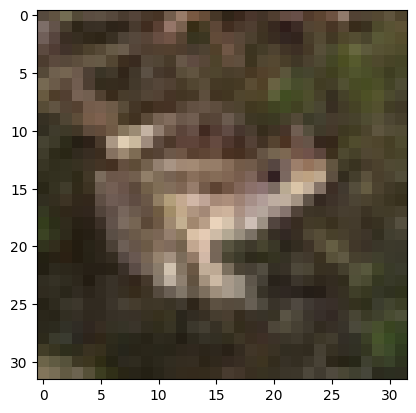

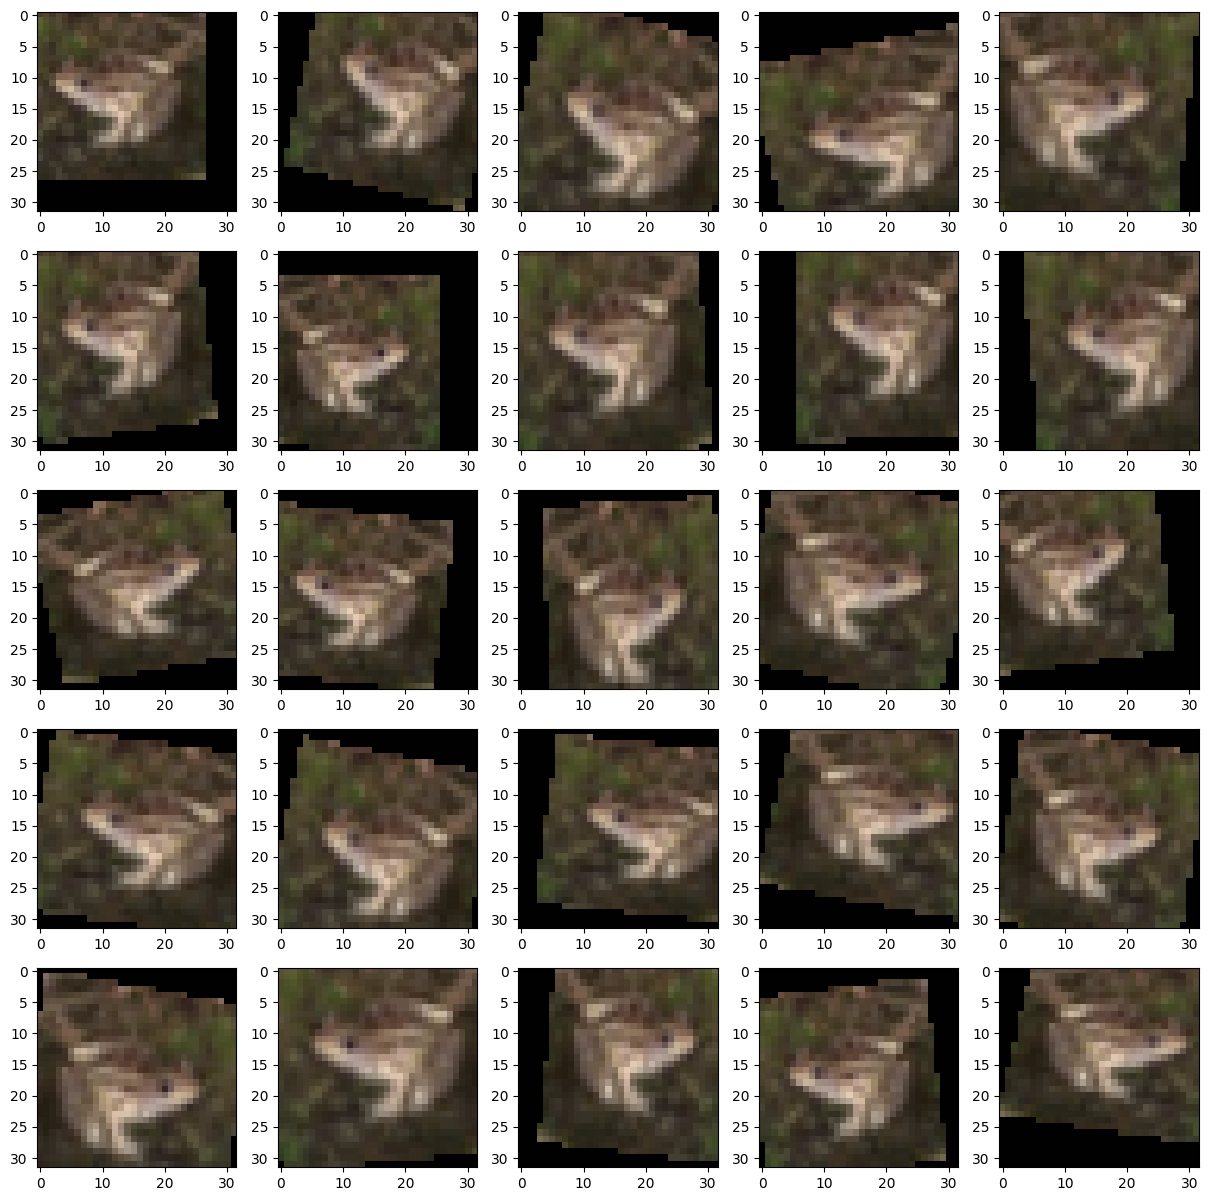

In [28]:
i=22
data_aug=datagen.flow(x=X_train[i:(i+1)], y=Y_train[i:(i+1)], batch_size=1)
plt.imshow(X_train[i])
plt.show()
plt.figure(figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    x_aug,y_aug=next(data_aug)
    plt.imshow(x_aug[0].astype("int"), vmin = 0, vmax = 255)

In [29]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64), 
                              steps_per_epoch=len(X_train)/64, 
                              epochs=40, 
                              validation_data=(X_val, Y_val),
                              verbose=1)

Epoch 1/40


/tmp/ipykernel_2264501/2265227106.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),


156/156 [==============================] - 4s 25ms/step - loss: 2.4131 - accuracy: 0.1827 - val_loss: 1.9591 - val_accuracy: 0.2860
Epoch 2/40
156/156 [==============================] - 4s 24ms/step - loss: 1.8113 - accuracy: 0.3254 - val_loss: 1.6604 - val_accuracy: 0.3835
Epoch 3/40
156/156 [==============================] - 4s 25ms/step - loss: 1.7041 - accuracy: 0.3719 - val_loss: 1.5582 - val_accuracy: 0.4252
Epoch 4/40
156/156 [==============================] - 4s 22ms/step - loss: 1.6411 - accuracy: 0.3909 - val_loss: 1.5305 - val_accuracy: 0.4407
Epoch 5/40
156/156 [==============================] - 4s 26ms/step - loss: 1.5853 - accuracy: 0.4200 - val_loss: 1.5084 - val_accuracy: 0.4577
Epoch 6/40
156/156 [==============================] - 4s 26ms/step - loss: 1.5404 - accuracy: 0.4403 - val_loss: 1.5057 - val_accuracy: 0.4708
Epoch 7/40
156/156 [==============================] - 4s 25ms/step - loss: 1.5081 - accuracy: 0.4518 - val_loss: 1.3982 - val_accuracy: 0.4906
Epoch 8/40

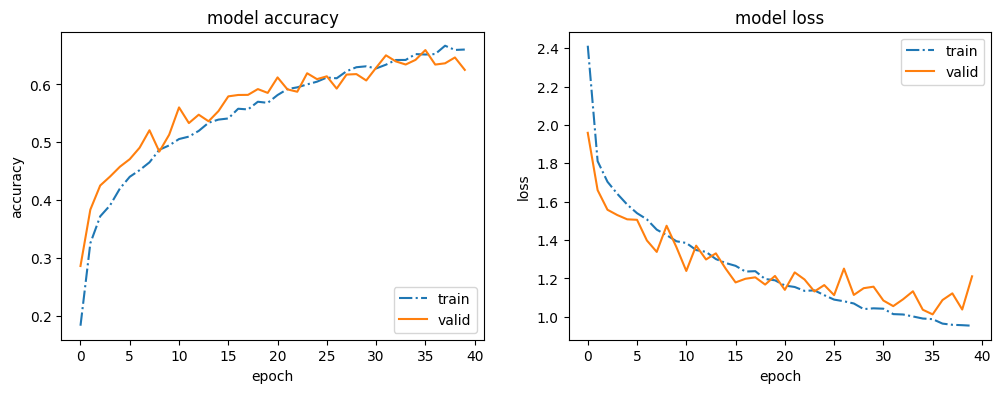

In [30]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [31]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res6 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with data augmentation']
)
pd.concat([res1,res2,res3,res4,res5,res6])

313/313 [==============================] - 2s 5ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038
cnn from scratch with normalization,0.5942
cnn from scratch with dropout,0.5761
cnn from scratch with batchnorm,0.6041
cnn from scratch with data augmentation,0.6248


#### Exercise
Try to beat the performace of the best network with your own neural network.  
*Hint: You might want to combine things from the neural networks above*